In [1]:
# Load libraries

# # Plotting utils 
import glob
import time
import warnings
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
from cartopy.util import add_cyclic_point
import matplotlib as matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
import pandas as pd 
import seaborn as sns

warnings.filterwarnings('ignore')


In [2]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [3]:
def getVarSeasonWgt(DS,var,seasonSel):

    month_length = DS.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    varWgtSeason = (DS[var] * weights).groupby("time.season").sum(dim="time").sel(season=seasonSel)

    return varWgtSeason


In [4]:
testDir     = '/glade/derecho/scratch/mdfowler/archive/'
               

case_IDs  = [
               'FLT2000_LP',
               'FLT2000_UA',    
               'FLT2000_CO',    
              ]

caseNames = [
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.cesm2_3_alpha16g.FluxTests_gustsOff_LargePond.002',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.cesm2_3_alpha16g.FluxTests_gustsOff_UA.002',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.cesm2_3_alpha16g.FluxTests_gustsOff_COARE.002',
]

for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h0.????-*'))
    listFiles_h2 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h2.????-*'))
    
    ## Now read in those files
    case_h0 = xr.open_mfdataset(listFiles_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h0 files loaded')
    
    case_h2 = xr.open_mfdataset(listFiles_h2, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h2 files loaded')
        
    ## Add case ID (short name) to the DS
    case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_h2      = case_h2.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    ## Return all the cases in a single dataset  
    if iCase==0:
        h0_LP = case_h0
        h2_LP = case_h2
    elif iCase==1:
        h0_UA = case_h0
        h2_UA = case_h2
    elif iCase==2:
        h0_CO = case_h0
        h2_CO = case_h2
        

*** Starting on case FLT2000_LP ***
h0 files loaded
h2 files loaded
*** Starting on case FLT2000_UA ***
h0 files loaded
h2 files loaded
*** Starting on case FLT2000_CO ***
h0 files loaded
h2 files loaded


In [5]:
## Very not official comparison for sanity check: recent case (#78) climo files (yrs 2-21)
outputDir = '/glade/campaign/cgd/amp/amwg/climo/b.e23_alpha16g.BLT1850.ne30_t232.078/yrs_2_21/'

listFiles_climo = np.sort(glob.glob(outputDir+'*.078_*climo.nc'))

climo78 = xr.open_mfdataset(listFiles_climo, 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)

In [6]:
climo78_annMean = climo78.mean(dim='time')

In [7]:
## Number of years?
print('LP dates span: ',h0_LP.time.values[0], ' to ', h0_LP.time.values[-1])
print('UA dates span: ',h0_UA.time.values[0], ' to ', h0_UA.time.values[-1])
print('CO dates span: ',h0_CO.time.values[0], ' to ', h0_CO.time.values[-1])


LP dates span:  0001-02-01 00:00:00  to  0011-01-01 00:00:00
UA dates span:  0001-02-01 00:00:00  to  0011-01-01 00:00:00
CO dates span:  0001-02-01 00:00:00  to  0011-01-01 00:00:00


In [8]:
h0_LP      = h0_LP.squeeze().assign_coords({"case":  'LP'})
h0_UA      = h0_UA.squeeze().assign_coords({"case":  'UA'})
h0_CO      = h0_CO.squeeze().assign_coords({"case":  'CO'})

all_h0    = xr.concat([h0_LP, h0_UA, h0_CO], "case") 


In [9]:
h2_LP      = h2_LP.squeeze().assign_coords({"case":  'LP'})
h2_UA      = h2_UA.squeeze().assign_coords({"case":  'UA'})
h2_CO      = h2_CO.squeeze().assign_coords({"case":  'CO'})

all_h2    = xr.concat([h2_LP, h2_UA, h2_CO], "case") 


In [10]:
## Ocean mask
fillOcnFrac_h0= np.full([2, len(h0_LP.lat.values), len(h0_LP.lon.values)], np.nan)
fillOcnFrac_h0[:,:,:] = h0_LP.OCNFRAC.isel(time=0)
fillOcnFrac_h0[np.where(fillOcnFrac_h0!=1)] = np.nan
## Get means 
fillOcnFrac_h0_mean = fillOcnFrac_h0[0,:,:]

## Also create ocean-only frac with time dimension
fillOcnFrac_h0_allTimes= np.full([len(h0_LP.time.values), len(h0_LP.lat.values), len(h0_LP.lon.values)], np.nan)
fillOcnFrac_h0_allTimes[:,:,:] = h0_LP.OCNFRAC.isel(time=0)
fillOcnFrac_h0_allTimes[np.where(fillOcnFrac_h0_allTimes!=1)] = np.nan


**Let's grab some obs too**

In [11]:
## Read in ERA-5 Monthly means for the same period 
filePath = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_fluxesAndRain.nc'
era5_obs = xr.open_dataset(filePath, decode_times=True)

## Add neutral 10m wind components 
fileNeut = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_neutral10mWinds.nc'
era5_neut = xr.open_dataset(fileNeut, decode_times=True)
era5_obs = xr.merge([era5_obs, era5_neut])

era5_obs = era5_obs.reindex(latitude=era5_obs.latitude[::-1])
era5_obs = era5_obs.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

# Now regrid the data
# Get model grid 
camGrid = h0_LP['LHFLX'].isel(time=0).load().squeeze()

# lhflx_era5 = era5_obs['slhf'].where(era5_obs['slhf'].values>-999)
lhflx_era5 = -era5_obs['slhf']/86400  # Divide fluxes by 86400 to get from J/m2 to W/m2; Add negative sign to match CAM convention 
regridERA5_lhflx = regrid_data(lhflx_era5, camGrid, method=1)

## NOW: use neutral winds for 10m u and v 
era5_u10_temp = era5_obs['u10n']
era5_v10_temp = era5_obs['v10n']
u10_era5 = np.sqrt(era5_u10_temp**2 + era5_v10_temp**2)
regridERA5_u10 = regrid_data(u10_era5, camGrid, method=1)

era5_prect_temp  = era5_obs['tp']
era5_prect_temp  =  era5_prect_temp * 1000.0  # Convert from m of water per day to mm/day
regridERA5_prect = regrid_data(era5_prect_temp, camGrid, method=1)

## Combine back into one xarray dataset
regridERA5 = regridERA5_lhflx.to_dataset()
regridERA5['U10'] = (('time','lat','lon'), regridERA5_u10.values)
regridERA5['tp'] = (('time','lat','lon'), regridERA5_prect.values)
# regridERA5 = xr.merge([regridERA5_lhflx, regridERA5_u10, regridERA5_prect])

## Select certain seasons and average over those 
iTimes_DJF = np.where( (regridERA5['time.month']==12) | (regridERA5['time.month']<=2) )[0]
iTimes_JJA = np.where( (regridERA5['time.month']>=6) &  (regridERA5['time.month']<=8) )[0]
iTimes_MAM = np.where( (regridERA5['time.month']>=3) &  (regridERA5['time.month']<=5) )[0]
iTimes_SON = np.where( (regridERA5['time.month']>=9) &  (regridERA5['time.month']<=11) )[0]

regridERA5_DJF = regridERA5.isel(time=iTimes_DJF).mean(dim='time')
regridERA5_JJA = regridERA5.isel(time=iTimes_JJA).mean(dim='time')
regridERA5_MAM = regridERA5.isel(time=iTimes_MAM).mean(dim='time')
regridERA5_SON = regridERA5.isel(time=iTimes_SON).mean(dim='time')
regridERA5_ANN = regridERA5.mean(dim='time')

era5_DJF_allTimes = regridERA5.isel(time=iTimes_DJF)


## Updated plotting options

In [12]:
longrid, latgrid = np.meshgrid(h0_LP['lon'], h0_LP['lat'])


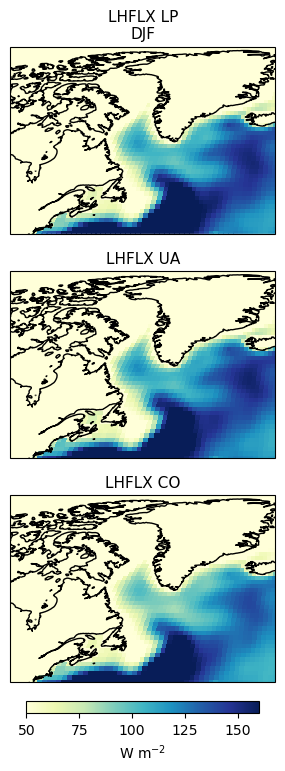

In [60]:
# - - - - - - - - - - - - - -  
# Raw values 
# - - - - - - - - - - - - - -  

varSel = 'LHFLX'
var_norm = mpl.colors.Normalize(vmin=50, vmax=160)
varMult = 1
cmapSel = 'YlGnBu'
unitsStr = 'W m$^{-2}$'
seasonSel = 'DJF'
varSeason = getVarSeasonWgt(all_h0,varSel,seasonSel)

# varSel = 'SHFLX'
# var_norm = mpl.colors.Normalize(vmin=50, vmax=160)
# varMult = 1
# cmapSel = 'YlGnBu'
# unitsStr = 'W m$^{-2}$'
# seasonSel = 'DJF'
# varSeason = getVarSeasonWgt(all_h0,varSel,seasonSel)

# varSel = 'U10'
# var_norm = mpl.colors.Normalize(vmin=1, vmax=10)
# varMult = 1
# cmapSel = 'YlGnBu'
# unitsStr = 'W m$^{-2}$'
# seasonSel = 'DJF'
# varSeason = getVarSeasonWgt(all_h0,varSel,seasonSel)

# varSel = 'TAUX'
# var_norm = mpl.colors.Normalize(vmin=0, vmax=10)
# varMult = 1
# cmapSel = 'YlGnBu'
# unitsStr = 'W m$^{-2}$'
# seasonSel = 'DJF'
# varSeason = getVarSeasonWgt(all_h0,varSel,seasonSel)


# Shamelessly stealing plot code from Brian's python pointers notebook (vol 4) 
# fig, ax = plt.subplots(nrows=len(all_h0.case.values), figsize=(10,10), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
fig, ax = plt.subplots(nrows=len(all_h0.case.values), figsize=(10,10), subplot_kw={"projection":ccrs.Robinson()})


for iInd in range(len(all_h0.case.values)):
    img1 = ax[iInd].pcolormesh(longrid, latgrid, varMult*varSeason.isel(case=iInd).values, 
                               transform=ccrs.PlateCarree(), norm=var_norm, cmap=cmapSel) 
    if iInd==0:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd).case.values)+'\n'+seasonSel, fontsize=11)
    else:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd).case.values), fontsize=11)

[a.coastlines() for a in ax]
# [a.set_extent([np.nanmin(h0_LP['lon'].values),np.nanmax(h0_LP['lon'].values),-20,20]) for a in ax]
# [a.set_extent([60,260,-5,5]) for a in ax]
[a.set_extent([280,340,40,85],crs=ccrs.PlateCarree()) for a in ax]

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=var_norm, cmap=cmapSel), ax=ax, shrink=0.3, label=unitsStr, orientation='horizontal', pad=0.025) 


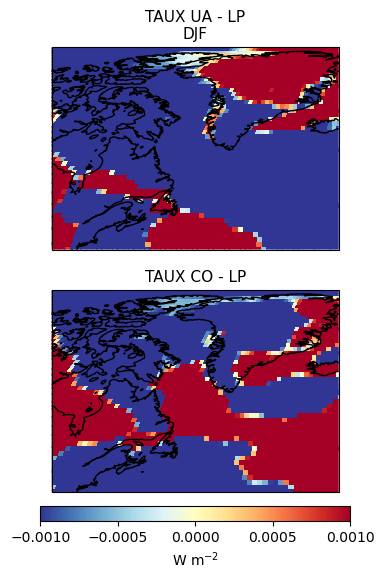

In [56]:
# - - - - - - - - - - - - - -  
# Difference from LP
# - - - - - - - - - - - - - -  

# varSel = 'LHFLX'
# varMult = 1
# var_norm = mpl.colors.Normalize(vmin=-15, vmax=15)
# unitsStr = 'W m$^{-2}$'

varSel = 'TAUX'
varMult = 1
var_norm = mpl.colors.Normalize(vmin=-1e-3, vmax=1e-3)
unitsStr = 'W m$^{-2}$'

# Shamelessly stealing plot code from Brian's python pointers notebook (vol 4) 
fig, ax = plt.subplots(nrows=len(all_h0.case.values)-1, figsize=(10,7), subplot_kw={"projection":ccrs.Robinson()})
for iInd in range(len(all_h0.case.values)-1):
    img1 = ax[iInd].pcolormesh(longrid, latgrid, 
                               varMult*(varSeason.isel(case=iInd+1).values - varSeason.isel(case=0).values), 
                               transform=ccrs.PlateCarree(), norm=var_norm, cmap='RdYlBu_r') 
    if iInd==0:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd+1).case.values)+' - LP\n'+seasonSel, fontsize=11)
    else:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd+1).case.values)+' - LP', fontsize=11)

[a.coastlines() for a in ax]
# [a.set_extent([np.nanmin(h0_LP['lon'].values),np.nanmax(h0_LP['lon'].values),-20,20]) for a in ax]
# [a.set_extent([60,260,-5,5]) for a in ax]
[a.set_extent([280,340,40,85],crs=ccrs.PlateCarree()) for a in ax]

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=var_norm, cmap='RdYlBu_r'), ax=ax, shrink=0.4, label=unitsStr, orientation='horizontal', pad=0.025) 


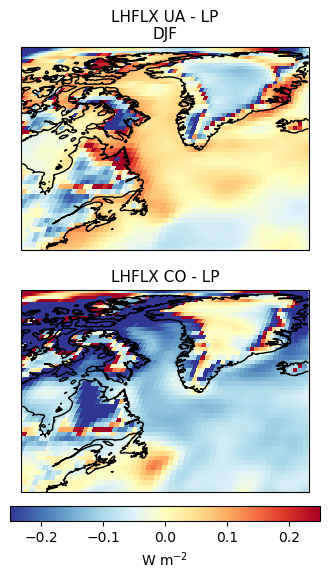

In [64]:
# - - - - - - - - - - - - - -  
# Difference from LP
# - - - - - - - - - - - - - -  

varSel = 'LHFLX'
varMult = 1
var_norm = mpl.colors.Normalize(vmin=-15, vmax=15)
unitsStr = 'W m$^{-2}$'

# varSel = 'TAUX'
# varMult = 1
# unitsStr = 'W m$^{-2}$'

var_norm = mpl.colors.Normalize(vmin=-0.25, vmax=0.25)


# Shamelessly stealing plot code from Brian's python pointers notebook (vol 4) 
fig, ax = plt.subplots(nrows=len(all_h0.case.values)-1, figsize=(10,7), subplot_kw={"projection":ccrs.Robinson()})
for iInd in range(len(all_h0.case.values)-1):
    img1 = ax[iInd].pcolormesh(longrid, latgrid, 
                               (varMult*(varSeason.isel(case=iInd+1).values - varSeason.isel(case=0).values))/(varMult*varSeason.isel(case=0).values), 
                               transform=ccrs.PlateCarree(), norm=var_norm, cmap='RdYlBu_r') 
    if iInd==0:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd+1).case.values)+' - LP\n'+seasonSel, fontsize=11)
    else:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd+1).case.values)+' - LP', fontsize=11)

[a.coastlines() for a in ax]
# [a.set_extent([np.nanmin(h0_LP['lon'].values),np.nanmax(h0_LP['lon'].values),-20,20]) for a in ax]
# [a.set_extent([60,260,-5,5]) for a in ax]
[a.set_extent([280,340,40,85],crs=ccrs.PlateCarree()) for a in ax]

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=var_norm, cmap='RdYlBu_r'), ax=ax, shrink=0.4, label=unitsStr, orientation='horizontal', pad=0.025) 


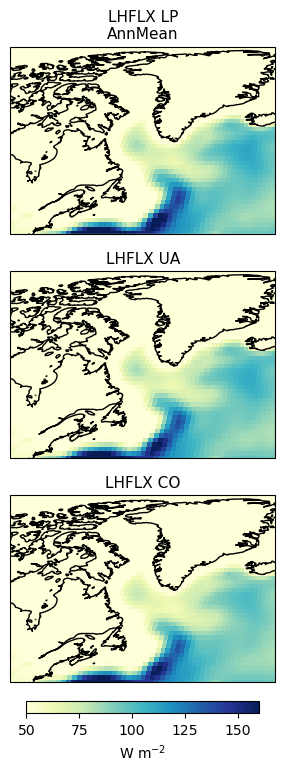

In [40]:
# - - - - - - - - - - - - - -  
# Raw values 
# - - - - - - - - - - - - - -  

varSel = 'LHFLX'
var_norm = mpl.colors.Normalize(vmin=50, vmax=160)
varMult = 1
cmapSel = 'YlGnBu'
unitsStr = 'W m$^{-2}$'

# varSel = 'SHFLX'
# var_norm = mpl.colors.Normalize(vmin=-20, vmax=105)
# varMult = 1
# cmapSel = 'Oranges'
# unitsStr = 'W m$^{-2}$'

# varSel = 'U10'
# var_norm = mpl.colors.Normalize(vmin=1, vmax=10)
# varMult = 1
# cmapSel = 'YlOrBr'
# unitsStr = 'm/s'

# varSel = 'PRECT'
# var_norm = mpl.colors.Normalize(vmin=0, vmax=11)
# varMult = 86400*1e3
# cmapSel = 'rainbow'
# unitsStr = 'mm d$^{-1}$'


# Shamelessly stealing plot code from Brian's python pointers notebook (vol 4) 
# fig, ax = plt.subplots(nrows=len(all_h0.case.values), figsize=(10,10), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
fig, ax = plt.subplots(nrows=len(all_h0.case.values), figsize=(10,10), subplot_kw={"projection":ccrs.Robinson()})


for iInd in range(len(all_h0.case.values)):
    img1 = ax[iInd].pcolormesh(longrid, latgrid, varMult*all_h0[varSel].isel(case=iInd).mean(dim='time').values, 
                               transform=ccrs.PlateCarree(), norm=var_norm, cmap=cmapSel) 
    if iInd==0:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd).case.values)+'\nAnnMean', fontsize=11)
    else:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd).case.values), fontsize=11)

[a.coastlines() for a in ax]
# [a.set_extent([np.nanmin(h0_LP['lon'].values),np.nanmax(h0_LP['lon'].values),-20,20]) for a in ax]
# [a.set_extent([60,260,-5,5]) for a in ax]
[a.set_extent([280,340,40,85],crs=ccrs.PlateCarree()) for a in ax]

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=var_norm, cmap=cmapSel), ax=ax, shrink=0.3, label=unitsStr, orientation='horizontal', pad=0.025) 


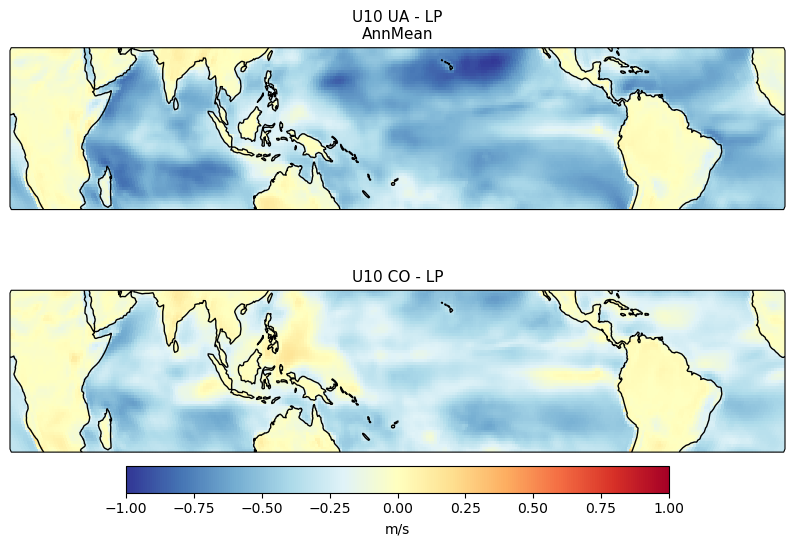

In [32]:
# - - - - - - - - - - - - - -  
# Difference from LP
# - - - - - - - - - - - - - -  

# varSel = 'LHFLX'
# varMult = 1
# var_norm = mpl.colors.Normalize(vmin=-15, vmax=15)
# unitsStr = 'W m$^{-2}$'

# varSel = 'SHFLX'
# varMult = 1
# var_norm = mpl.colors.Normalize(vmin=-10, vmax=10)
# unitsStr = 'W m$^{-2}$'

varSel = 'U10'
var_norm = mpl.colors.Normalize(vmin=-1, vmax=1)
varMult = 1
unitsStr = 'm/s'

# varSel = 'PRECT'
# varMult = 86400*1e3
# var_norm = mpl.colors.Normalize(vmin=-2, vmax=2)
# unitsStr = 'mm d$^{-1}$'


# Shamelessly stealing plot code from Brian's python pointers notebook (vol 4) 
fig, ax = plt.subplots(nrows=len(all_h0.case.values)-1, figsize=(10,7), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
for iInd in range(len(all_h0.case.values)-1):
    img1 = ax[iInd].pcolormesh(longrid, latgrid, 
                               varMult*(all_h0[varSel].isel(case=iInd+1).mean(dim='time').values - all_h0[varSel].isel(case=0).mean(dim='time').values), 
                               transform=ccrs.PlateCarree(), norm=var_norm, cmap='RdYlBu_r') 
    if iInd==0:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd+1).case.values)+' - LP\nAnnMean', fontsize=11)
    else:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd+1).case.values)+' - LP', fontsize=11)

[a.coastlines() for a in ax]
# [a.set_extent([np.nanmin(h0_LP['lon'].values),np.nanmax(h0_LP['lon'].values),-20,20]) for a in ax]
[a.set_extent([60,260,-5,5]) for a in ax]

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=var_norm, cmap='RdYlBu_r'), ax=ax, shrink=0.7, label=unitsStr, orientation='horizontal', pad=0.025) 


**If bias maps are of interest, those are below**

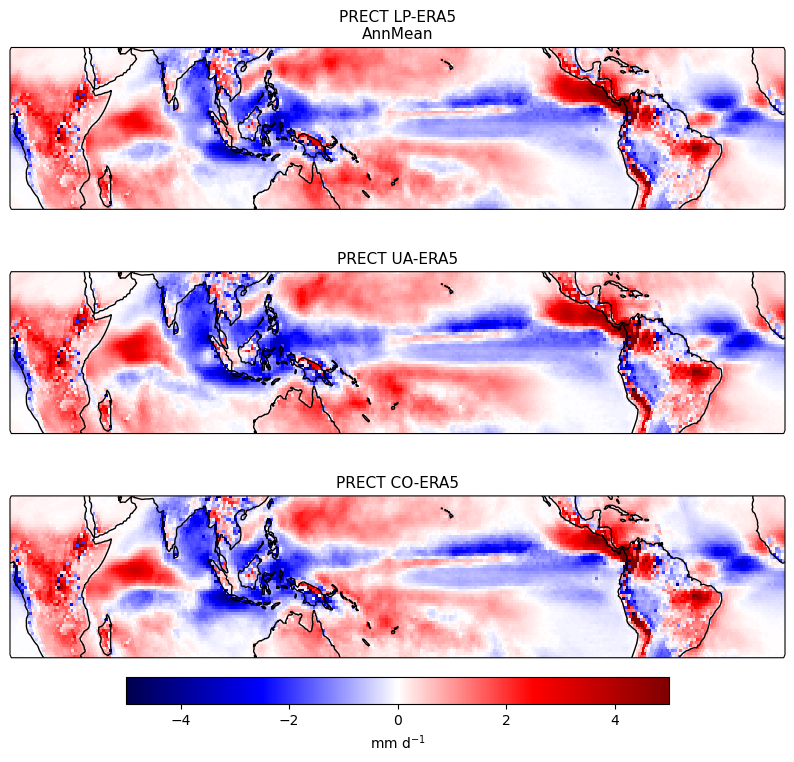

In [22]:
# - - - - - - - - - - - - - -  
# Biases from ERA5
# - - - - - - - - - - - - - -

# varSel   = 'LHFLX'
# varMult = 1
# var_norm = mpl.colors.Normalize(vmin=-40, vmax=40)
# cmapSel  = 'seismic'
# unitsStr = 'W m$^{-2}$'
# obsDS    = regridERA5_ANN
# obsVar   = 'slhf'

# varSel   = 'U10'
# varMult = 1
# var_norm = mpl.colors.Normalize(vmin=-3, vmax=3)
# cmapSel  = 'seismic'
# unitsStr = 'm/s'
# obsDS    = regridERA5_ANN
# obsVar   = 'U10'


varSel   = 'PRECT'
varMult = 86400*1e3
var_norm = mpl.colors.Normalize(vmin=-5, vmax=5)
cmapSel  = 'seismic'
unitsStr = 'mm d$^{-1}$'
obsDS    = regridERA5_ANN
obsVar   = 'tp'


# Shamelessly stealing plot code from Brian's python pointers notebook (vol 4) 
fig, ax = plt.subplots(nrows=len(all_h0.case.values), figsize=(10,10), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
for iInd in range(len(all_h0.case.values)):
    img1 = ax[iInd].pcolormesh(longrid, latgrid, 
                               (varMult*all_h0[varSel].isel(case=iInd).mean(dim='time').values) - obsDS[obsVar].values, 
                               transform=ccrs.PlateCarree(), norm=var_norm, cmap=cmapSel) 
    if iInd==0:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd).case.values)+'-ERA5\nAnnMean', fontsize=11)
    else:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd).case.values)+'-ERA5', fontsize=11)

[a.coastlines() for a in ax]
# [a.set_extent([np.nanmin(h0_LP['lon'].values),np.nanmax(h0_LP['lon'].values),-20,20]) for a in ax]
[a.set_extent([60,260,-5,5]) for a in ax]

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=var_norm, cmap=cmapSel), ax=ax, shrink=0.7, label=unitsStr, orientation='horizontal', pad=0.025) 


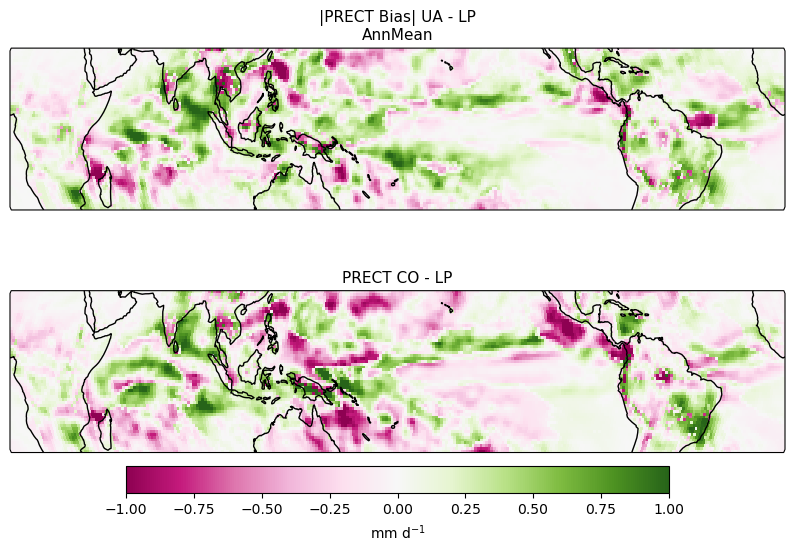

In [23]:
# - - - - - - - - - - - - - -  
# Difference in |bias| from LP
# - - - - - - - - - - - - - -  

# varSel = 'U10'
# varMult = 1
# var_norm = mpl.colors.Normalize(vmin=-1, vmax=1)
# unitsStr = 'm/s'

varSel = 'PRECT'
varMult = 86400*1e3
var_norm = mpl.colors.Normalize(vmin=-1, vmax=1)
unitsStr = 'mm d$^{-1}$'


LPbias = (varMult*all_h0[varSel].isel(case=0).mean(dim='time').values) - obsDS[obsVar].values

# Shamelessly stealing plot code from Brian's python pointers notebook (vol 4) 
fig, ax = plt.subplots(nrows=len(all_h0.case.values)-1, figsize=(10,7), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
for iInd in range(len(all_h0.case.values)-1):
    thisBias = (varMult*all_h0[varSel].isel(case=iInd+1).mean(dim='time').values) - obsDS[obsVar].values
    
    img1 = ax[iInd].pcolormesh(longrid, latgrid, 
                               np.abs(thisBias)-np.abs(LPbias), 
                               transform=ccrs.PlateCarree(), norm=var_norm, cmap='PiYG') 
    if iInd==0:
        ax[iInd].set_title('|'+varSel+' Bias| '+str(all_h0[varSel].isel(case=iInd+1).case.values)+' - LP\nAnnMean', fontsize=11)
    else:
        ax[iInd].set_title(varSel+' '+str(all_h0[varSel].isel(case=iInd+1).case.values)+' - LP', fontsize=11)

[a.coastlines() for a in ax]
# [a.set_extent([np.nanmin(h0_LP['lon'].values),np.nanmax(h0_LP['lon'].values),-20,20]) for a in ax]
# [a.set_extent([40,300,-20,20]) for a in ax]
[a.set_extent([60,260,-5,5]) for a in ax]

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=var_norm, cmap='PiYG'), ax=ax, shrink=0.7, label=unitsStr, orientation='horizontal', pad=0.025) 


## Distributions??

In [32]:
all_h2_tropics = all_h2.isel(lat=np.where((all_h2.lat.values>=-15) & (all_h2.lat.values<=15) )[0])

nLat = len(all_h2_tropics.lat.values)
nLon = len(all_h2_tropics.lon.values)
nTimes = len(all_h2_tropics.time.values)



In [34]:
ilats = np.where( (all_h2.lat.values>=-15) & (all_h2.lat.values<=15) )[0]
ocnMask_tropics = np.full([nTimes,nLat,nLon], np.nan)
for iT in range(nTimes):
    ocnMask_tropics[iT,:,:] = fillOcnFrac_h0_allTimes[0,ilats,:]


KeyboardInterrupt: 

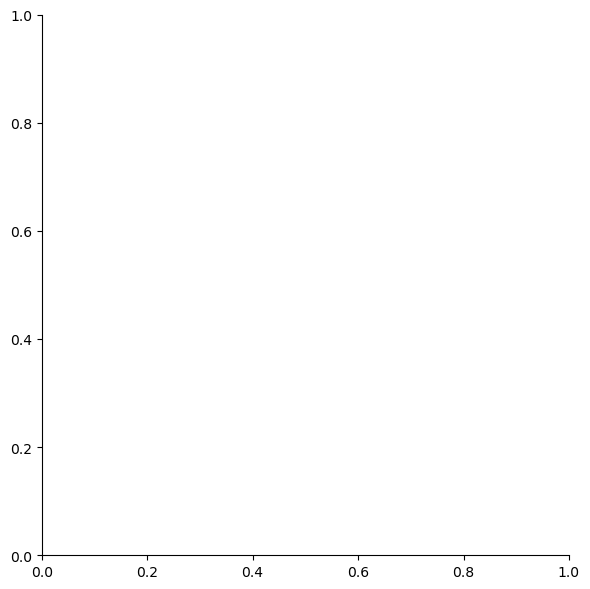

In [38]:
numEl = nTimes*nLat*nLon 

varName = 'PRECT'
varMult = 86400*1e3

caseLP  = np.squeeze( varMult*(ocnMask_tropics*all_h2_tropics[varName].isel(case=0).values).reshape(numEl,1) )
caseUA  = np.squeeze( varMult*(ocnMask_tropics*all_h2_tropics[varName].isel(case=1).values).reshape(numEl,1) )
caseCO  = np.squeeze( varMult*(ocnMask_tropics*all_h2_tropics[varName].isel(case=2).values).reshape(numEl,1) )

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({varName: caseLP, 'case': str(all_h2_tropics.isel(case=0).case.values)}),
         pd.DataFrame.from_dict({varName: caseUA, 'case': str(all_h2_tropics.isel(case=1).case.values)}),
         pd.DataFrame.from_dict({varName: caseCO, 'case': str(all_h2_tropics.isel(case=2).case.values)}),
         ])

# Make plot 
g = sns.displot(dfReal, x=varName, hue='case', kind='kde', height=6, cut=0, 
                log_scale=False, common_norm = False, alpha=0.7,
                 # palette=['black','gray','orangered','blue','darkorange'])
                 palette=['gray','orangered','blue'])

g.ax.set_xlabel(unitsString,fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
g.ax.set_title('(Tropics and all months)\n Daily ' +varName+' (No avg in time/space)',fontsize=16)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)

g.ax.set_xlim([0,18])


In [40]:
del caseLP,caseUA,caseCO

In [41]:
del dfReal

## Quick look figures

In [12]:
def quickPlot(varSel,cLims,dLims):
    DS_LP = h0_LP
    DS_UA = h0_UA
    DS_CO = h0_CO
    
    fig,axs = plt.subplots(3,2,figsize=(10,9), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    
    plt.gcf().text(0.42, 0.9, 'Annual Mean '+varSel, fontsize=14)
    
    axs[0].set_title('#78 Climo')
    axs[0].coastlines()
    cplt = axs[0].contourf(climo78_annMean.lon.values, climo78_annMean.lat.values, climo78_annMean[varSel].values, 
                    cLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
    
    
    axs[1].set_title(str(DS_LP.case.values)+' (yrs 1-2)')
    axs[1].coastlines()
    cplt = axs[1].contourf(DS_LP.lon.values, DS_LP.lat.values, DS_LP[varSel].mean(dim='time').values, 
                    cLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
    
    
    axs[2].set_title(str(DS_UA.case.values)+' (yrs 1-2)')
    axs[2].coastlines()
    cplt = axs[2].contourf(DS_UA.lon.values, DS_UA.lat.values, DS_UA[varSel].mean(dim='time').values, 
                    cLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
    
    
    axs[3].set_title(str(DS_CO.case.values)+' (yrs 1-2)')
    axs[3].coastlines()
    cplt = axs[3].contourf(DS_CO.lon.values, DS_CO.lat.values, DS_CO[varSel].mean(dim='time').values, 
                    cLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[3].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.1, 0.013])
    cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
    
    
    ## - - - - - - - 
    ## Difference from LP?
    ## - - - - - - - 
    axs[4].set_title('UA - LP (yrs 1-2)')
    axs[4].coastlines()
    cplt = axs[4].contourf(DS_UA.lon.values, DS_UA.lat.values, DS_UA[varSel].mean(dim='time').values -  DS_LP[varSel].mean(dim='time').values, 
                    dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
    
    
    axs[5].set_title('CO - LP(yrs 1-2)')
    axs[5].coastlines()
    cplt = axs[5].contourf(DS_CO.lon.values, DS_CO.lat.values, DS_CO[varSel].mean(dim='time').values -  DS_LP[varSel].mean(dim='time').values, 
                    dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[5].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.1, 0.013])
    cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
    

    return axs

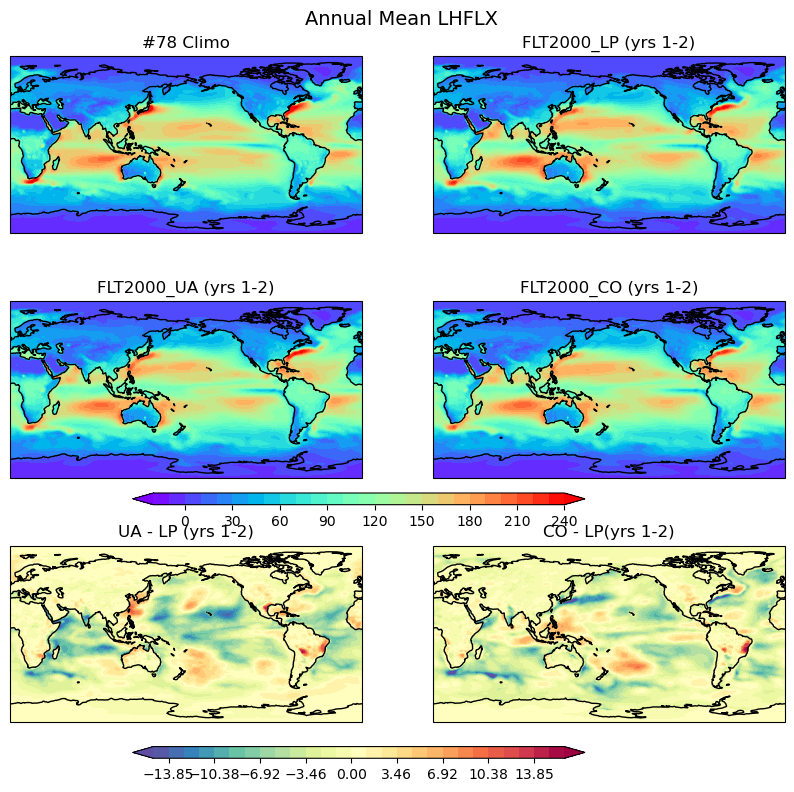

In [18]:
varSel = 'LHFLX'

cMin = -20
cMax = 240
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 15 
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot(varSel,cLims,dLims)

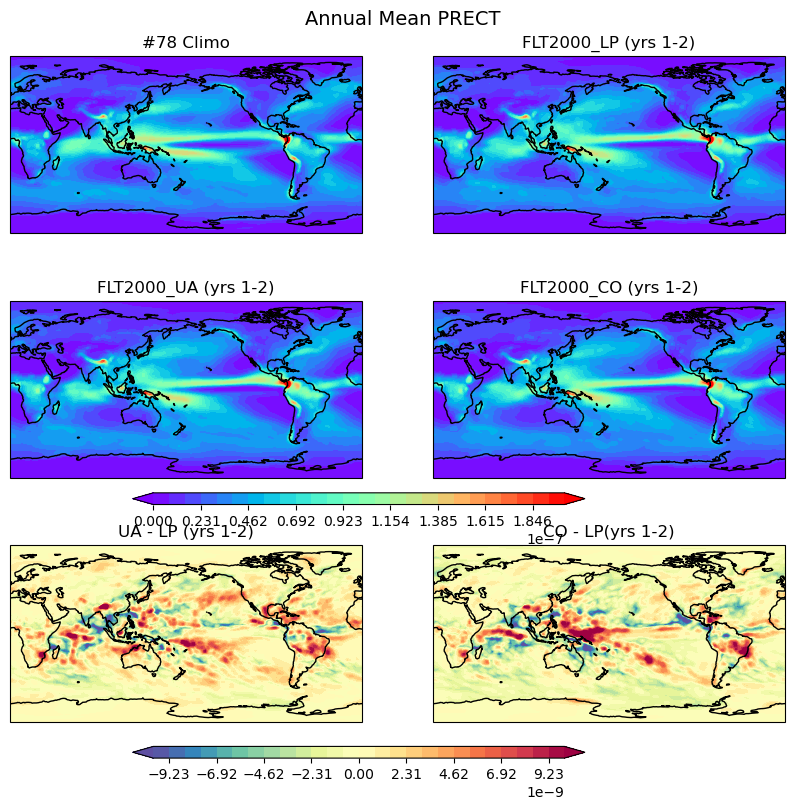

In [14]:
varSel = 'PRECT'

cMin = 0
cMax = 2e-7
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 1e-8 
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot(varSel,cLims,dLims)

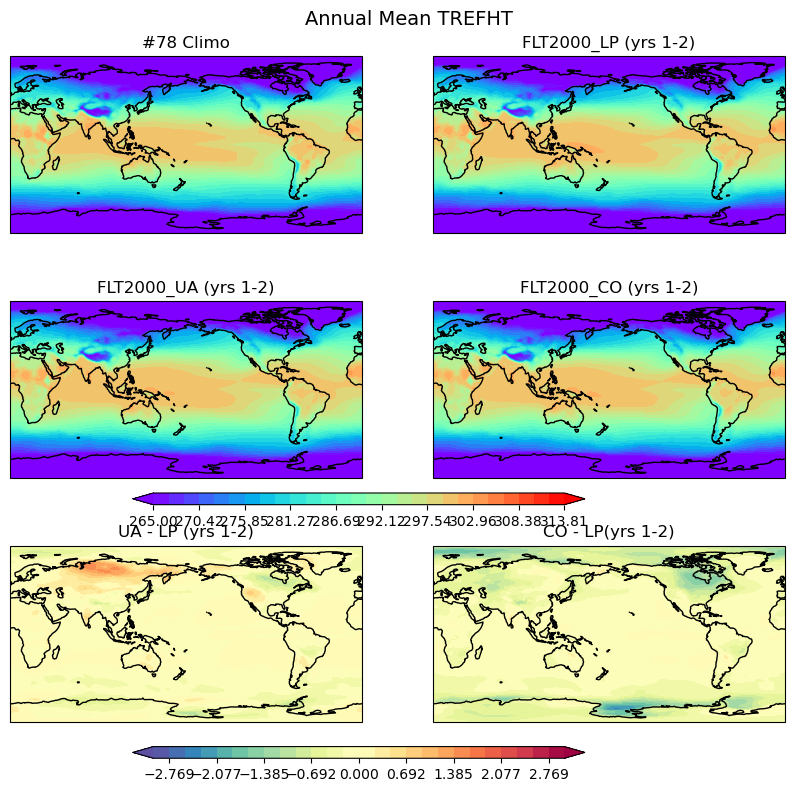

In [15]:
varSel = 'TREFHT'

cMin = 265
cMax = 312
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 3
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot(varSel,cLims,dLims)

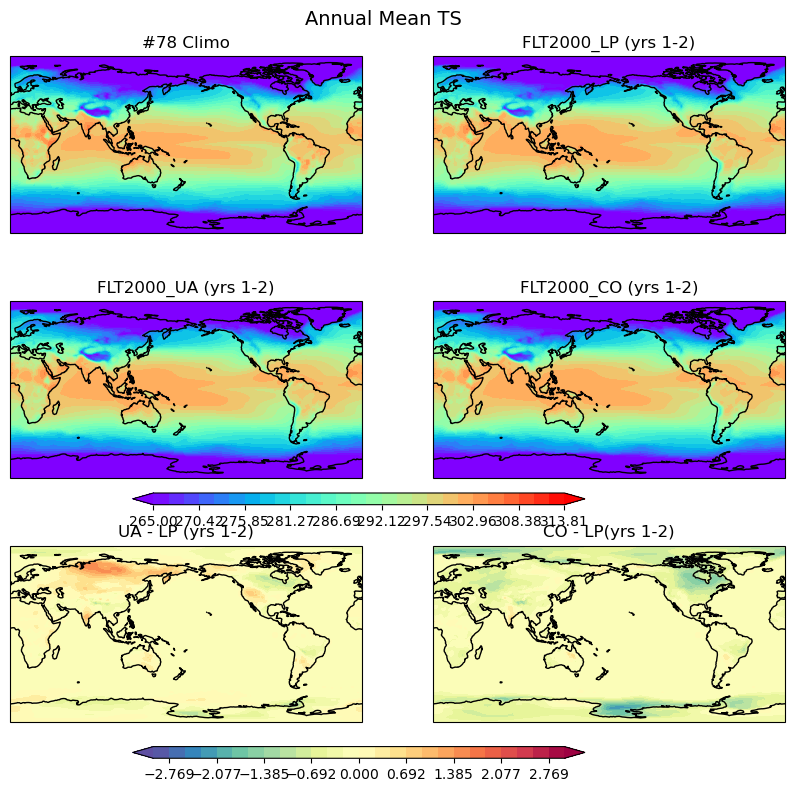

In [17]:
varSel = 'TS'

cMin = 265
cMax = 312
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 3
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot(varSel,cLims,dLims)

**Zoom into Lab Sea region**

In [39]:
def quickPlot_LabSea(varSel,cLims,dLims):
    DS_LP = h0_LP
    DS_UA = h0_UA
    DS_CO = h0_CO
    
    fig,axs = plt.subplots(3,2,figsize=(10,11), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    
    plt.gcf().text(0.42, 0.9, 'Annual Mean '+varSel, fontsize=14)
    
    axs[0].set_title('#78 Climo')
    axs[0].coastlines()
    axs[0].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[0].contourf(climo78_annMean.lon.values, climo78_annMean.lat.values, climo78_annMean[varSel].values, 
                    cLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
    
    
    axs[1].set_title(str(DS_LP.case.values))
    axs[1].coastlines()
    axs[1].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[1].contourf(DS_LP.lon.values, DS_LP.lat.values, DS_LP[varSel].mean(dim='time').values, 
                    cLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
    
    
    axs[2].set_title(str(DS_UA.case.values))
    axs[2].coastlines()
    axs[2].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[2].contourf(DS_UA.lon.values, DS_UA.lat.values, DS_UA[varSel].mean(dim='time').values, 
                    cLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
    
    
    axs[3].set_title(str(DS_CO.case.values))
    axs[3].coastlines()
    axs[3].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[3].contourf(DS_CO.lon.values, DS_CO.lat.values, DS_CO[varSel].mean(dim='time').values, 
                    cLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[3].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.02, ax_position.width+0.1, 0.013])
    cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
    cbar.ax.locator_params(nbins=5)
    
    ## - - - - - - - 
    ## Difference from LP?
    ## - - - - - - - 
    axs[4].set_title('UA - LP ')
    axs[4].coastlines()
    axs[4].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[4].contourf(DS_UA.lon.values, DS_UA.lat.values, DS_UA[varSel].mean(dim='time').values -  DS_LP[varSel].mean(dim='time').values, 
                    dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
    
    
    axs[5].set_title('CO - LP')
    axs[5].coastlines()
    axs[5].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[5].contourf(DS_CO.lon.values, DS_CO.lat.values, DS_CO[varSel].mean(dim='time').values -  DS_LP[varSel].mean(dim='time').values, 
                    dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[5].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.1, 0.013])
    cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
    cbar.ax.locator_params(nbins=5)
    

    return axs

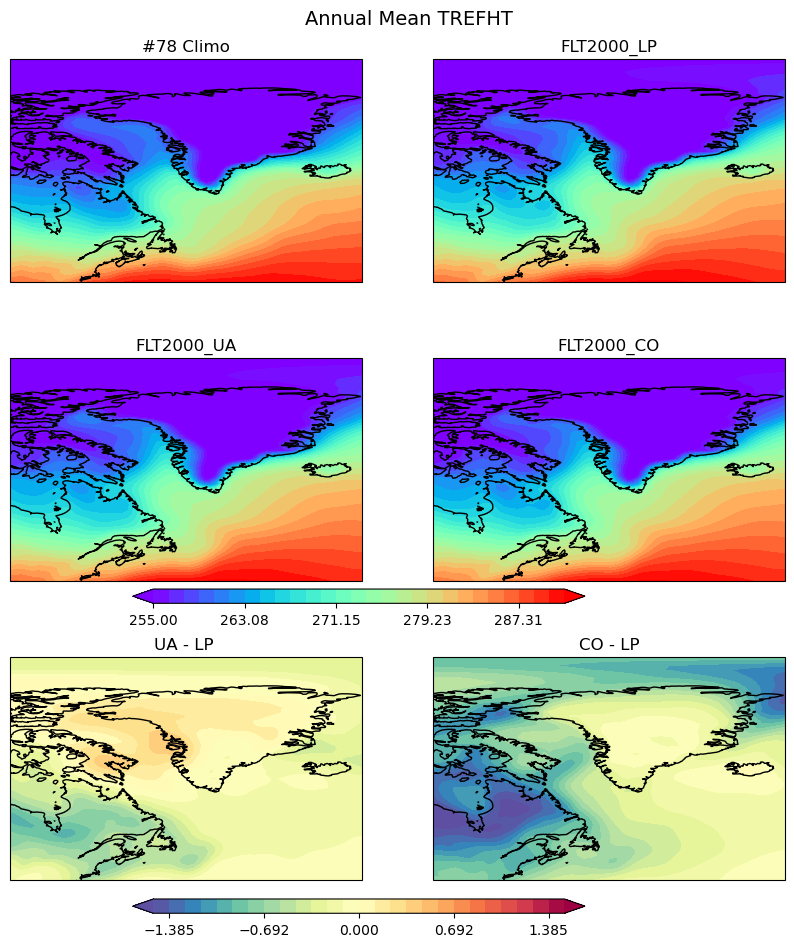

In [68]:
varSel = 'TREFHT'

cMin = 255
cMax = 290
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 1.5
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot_LabSea(varSel,cLims,dLims)

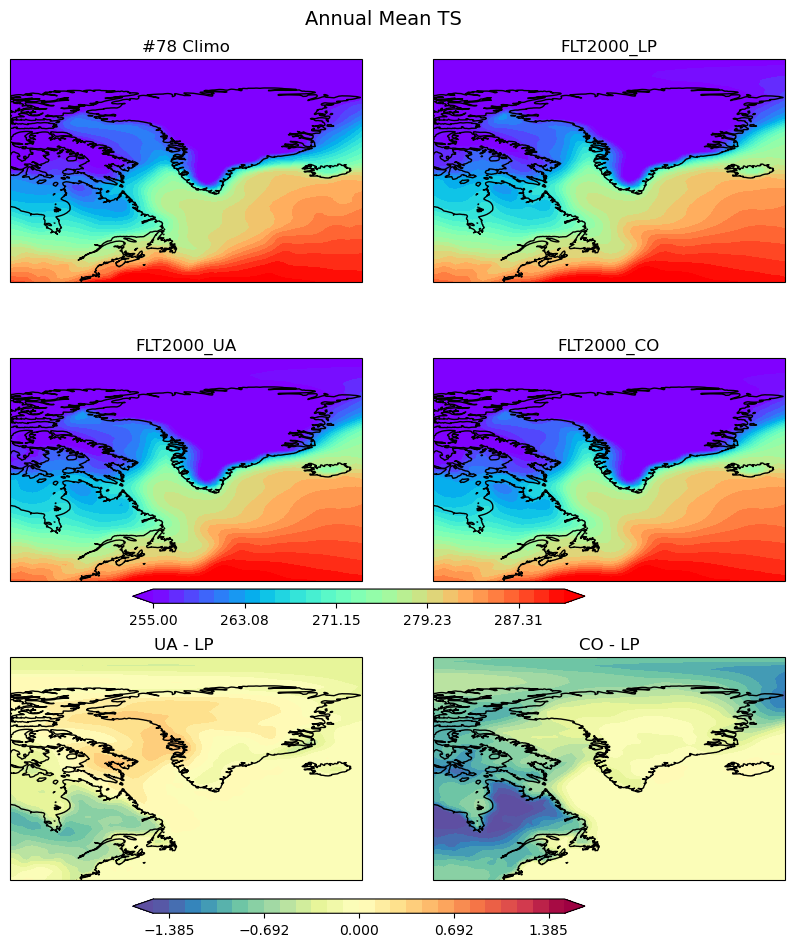

In [40]:
varSel = 'TS'

cMin = 255
cMax = 290
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 1.5
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot_LabSea(varSel,cLims,dLims)

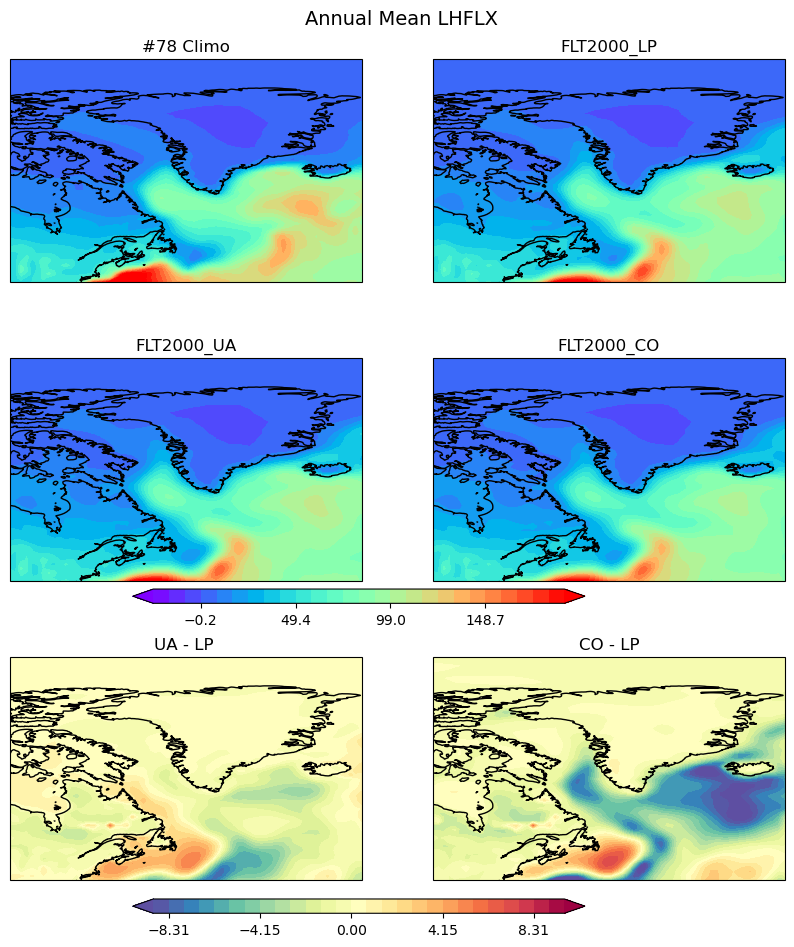

In [43]:
varSel = 'LHFLX'

cMin = -25
cMax = 190
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 9 
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot_LabSea(varSel,cLims,dLims)

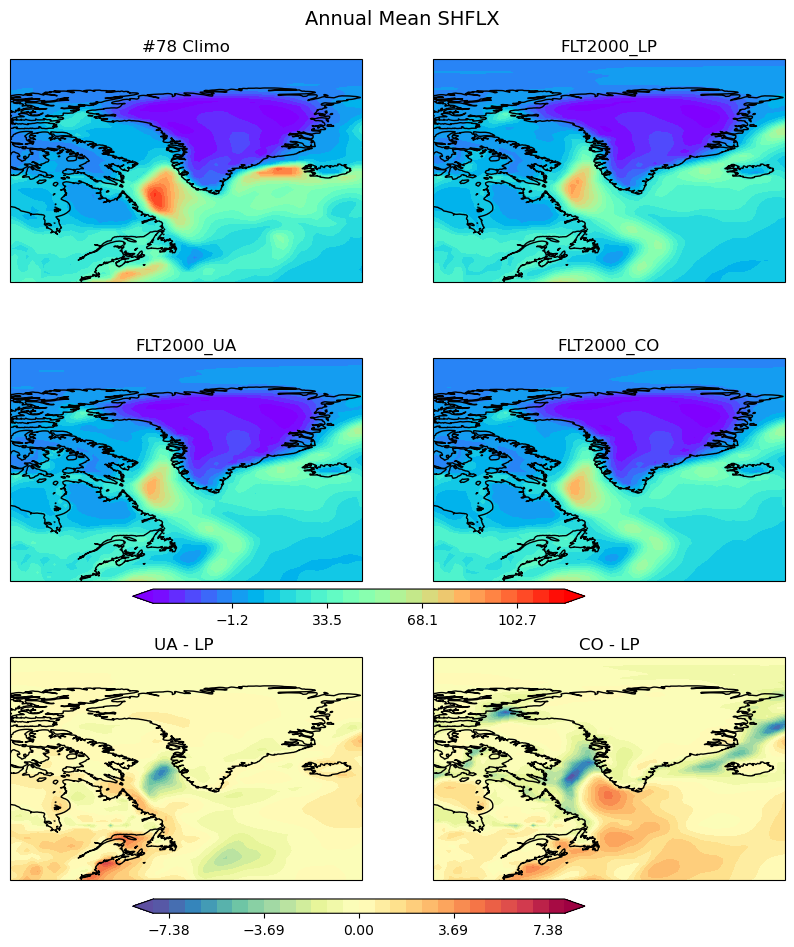

In [42]:
varSel = 'SHFLX'

cMin = -30
cMax = 120
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 8 
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot_LabSea(varSel,cLims,dLims)

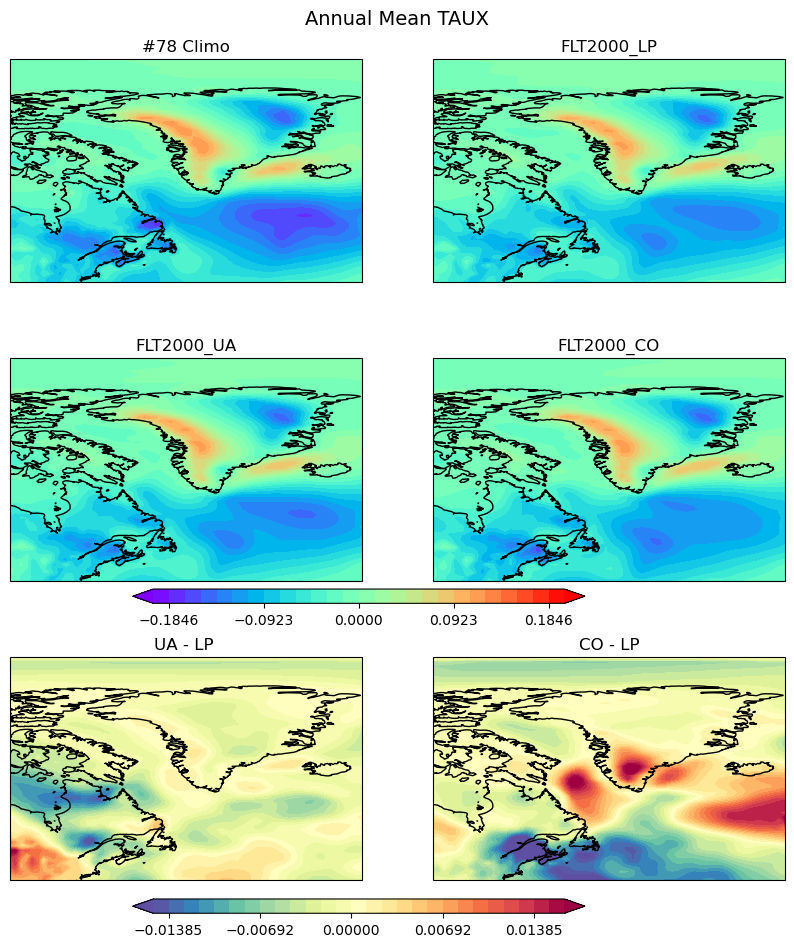

In [59]:
varSel = 'TAUX'

cMin = -2e-1
cMax = 2e-1
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 1.5e-2 
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot_LabSea(varSel,cLims,dLims)

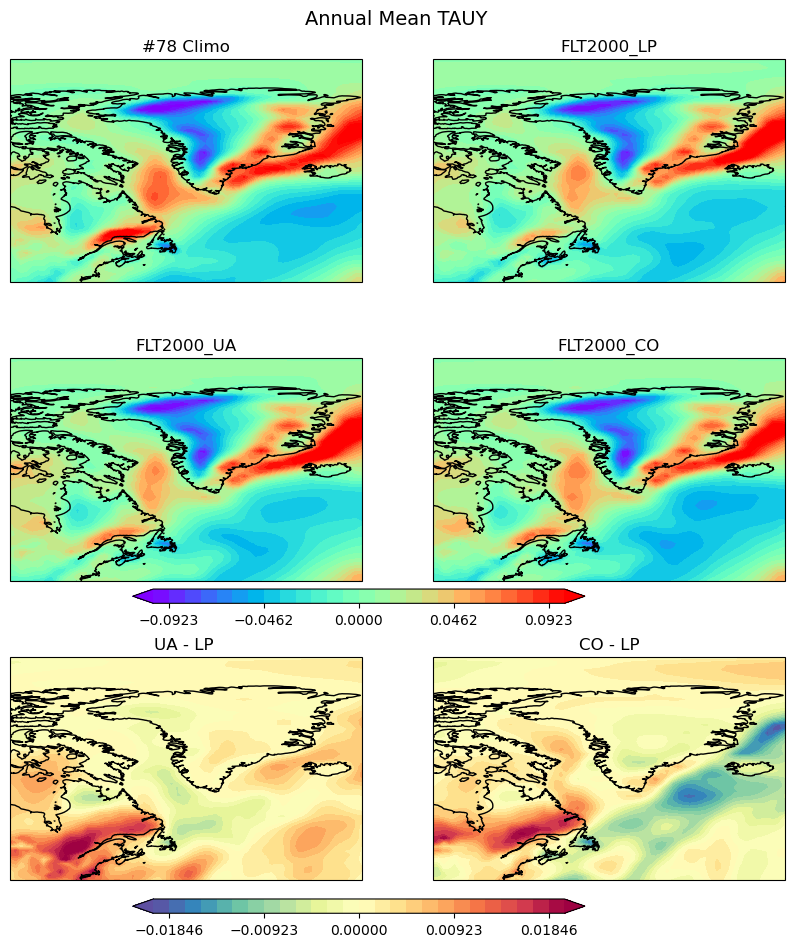

In [60]:
varSel = 'TAUY'

cMin = -0.1
cMax = 0.1
cStep = (cMax-cMin)/26
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 2e-2 
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot_LabSea(varSel,cLims,dLims)

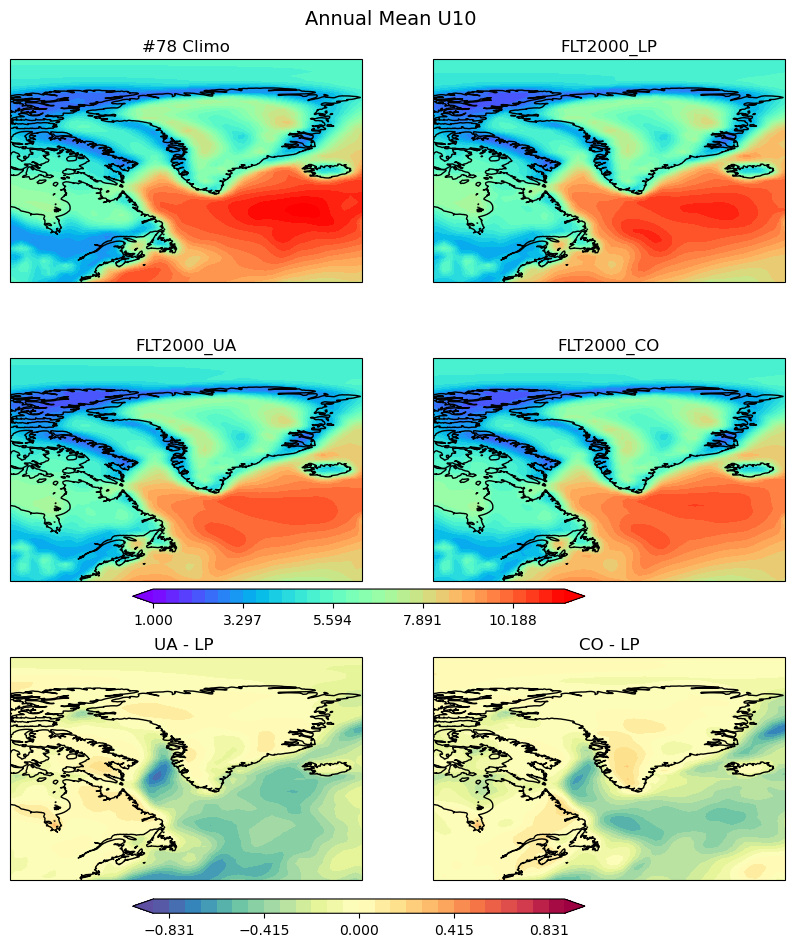

In [62]:
varSel = 'U10'

cMin = 1
cMax = 11.5
cStep = (cMax-cMin)/32
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 0.9
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot_LabSea(varSel,cLims,dLims)

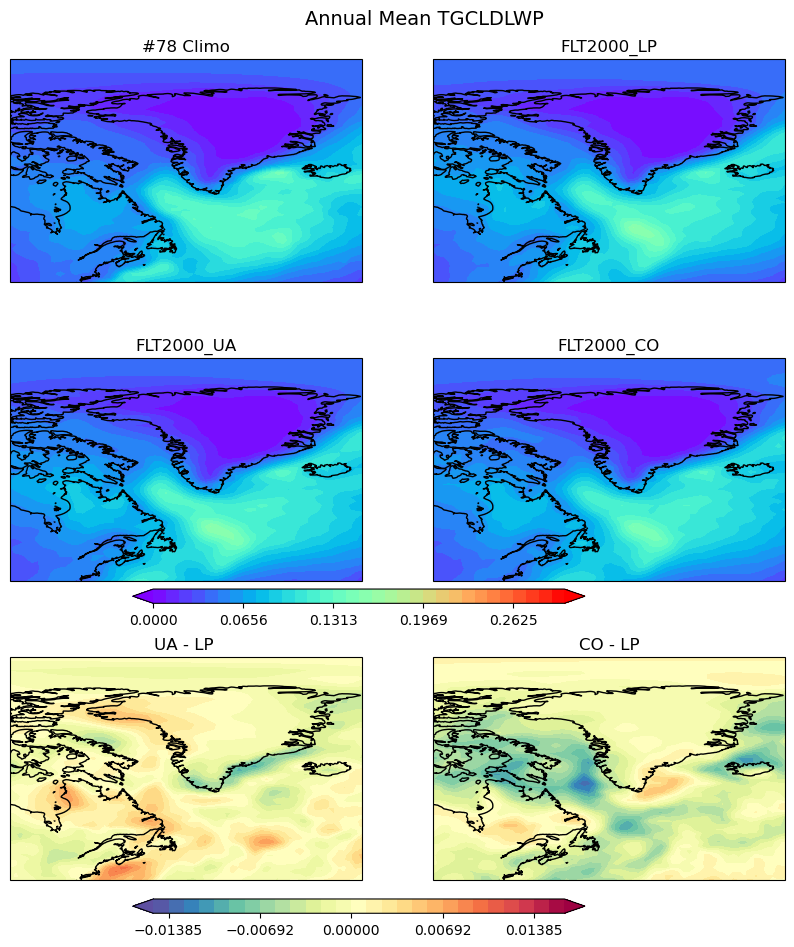

In [67]:
varSel = 'TGCLDLWP'

cMin = 0
cMax = 0.3
cStep = (cMax-cMin)/32
cLims = np.arange(cMin,cMax+cStep, cStep)

dMax = 0.015
dStep = (2*dMax)/26
dLims = np.arange(-dMax, dMax+dStep, dStep) 

axs = quickPlot_LabSea(varSel,cLims,dLims)